In [1]:
# Imports
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.inspection import PartialDependenceDisplay
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr, ks_2samp

In [2]:
def df_gen(RESULTS_DIR, NSHARDS = 10):  
  dfs = []
  for shard_idx in range(NSHARDS):
    filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
    print(filename)

    with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
      lines = f.readlines()
      records = map(json.loads, lines)
      dfs.append(pd.DataFrame.from_records(records))

  # Construct df and remove nans
  results_df = pd.concat(dfs)
  results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
  # results_df.dropna(axis=0, inplace=True)
  del dfs
  return results_df

In [5]:
def plot_model_perf_vs_feature_noise_dim(dfs, models, metric, noise_feature_dims):
    plot_data = []
    for i, df in enumerate(dfs):
        # Select the metric columns for the models
        df_copy = df[[f'{model}__{metric}' for model in models]].copy()
        # Add the feature dimension column
        df_copy['feature_dim'] = noise_feature_dims[i]
        plot_data.append(df_copy)

    combined_df_wide = pd.concat(plot_data, ignore_index=True)


    # --- 3. Reshape Data from Wide to Long Format ---
    # This is the key step. We use `pd.melt` to turn the model columns
    # into rows, making the data suitable for seaborn's `hue` parameter.

    id_vars = ['feature_dim']
    value_vars = [f'{model}__{metric}' for model in models]

    combined_df_long = pd.melt(
        combined_df_wide,
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='model_metric', # New column for the original column names
        value_name='performance_score' # New column for the performance values
    )

    # Clean up the model names (e.g., 'GCN__test_rocauc_ovr' -> 'GCN')
    combined_df_long['model'] = combined_df_long['model_metric'].str.replace(f'__{metric}', '', regex=False)


    # --- 4. Create the Combined Boxplot ---
    # Now we create a single plot, using `hue` to differentiate the models.

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    sns.boxplot(
        x='feature_dim',
        y='performance_score',
        hue='model', # This tells seaborn to use different colors for each model
        data=combined_df_long,
        ax=ax,
        palette='muted' # A nice color palette
    )

    # --- 5. Customize and Show the Plot ---
    ax.set_title(f'Model Performance ({metric}) vs. Noise Feature Dimension', fontsize=16, fontweight='bold')
    ax.set_xlabel('Number of Noise Features', fontsize=12)
    ax.set_ylabel('Performance Score (ROC AUC)', fontsize=12)
    ax.legend(title='Model') # Add a legend to identify the colors

    plt.tight_layout()
    plt.show()

In [9]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/1'
df = df_gen(RESULTS_DIR = RESULTS_DIR) 

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


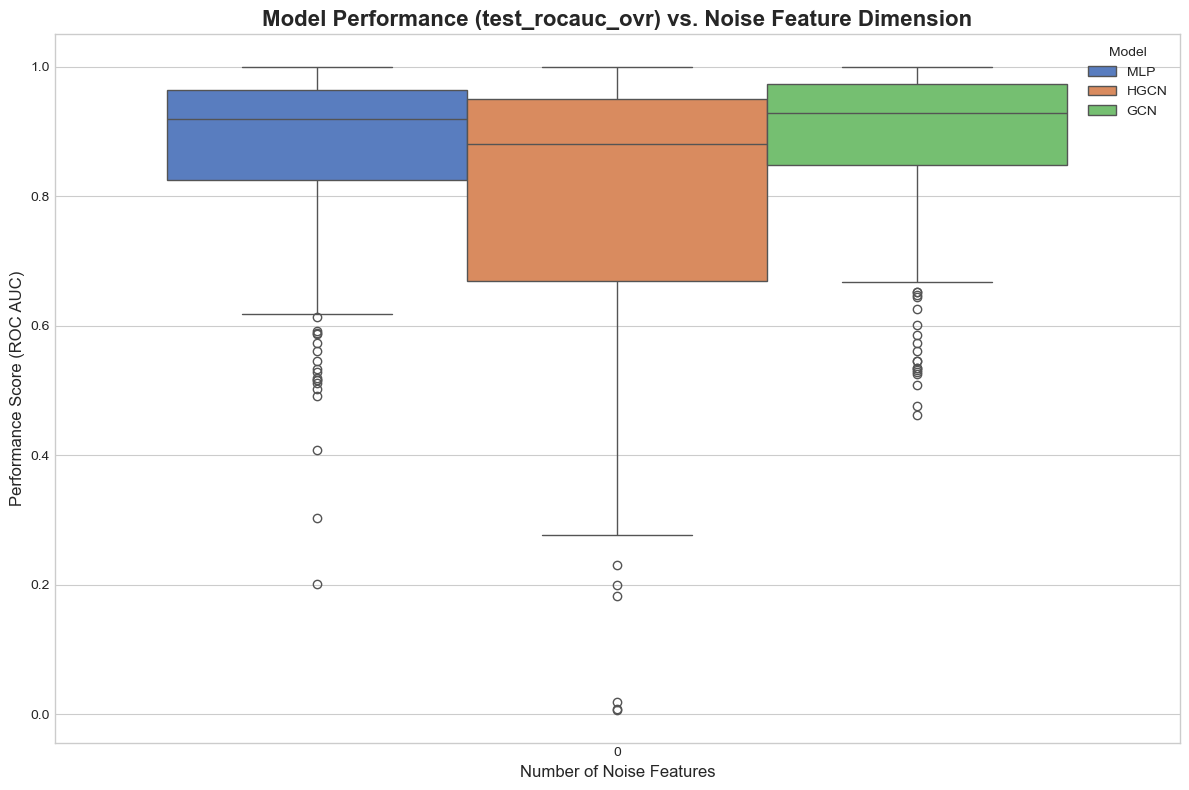

In [10]:
plot_model_perf_vs_feature_noise_dim([df], models = ['MLP', 'HGCN', 'GCN'], metric = 'test_rocauc_ovr', noise_feature_dims=[0])